In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer
import joblib


import matplotlib.pyplot as plt
import seaborn as sns
import os
from custom_preprocessing import MFCCPreprocessor

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.linear_model import LogisticRegression

In [2]:
cwd = os.getcwd()

In [3]:
parent_dir = os.path.dirname(cwd)
parent_dir = os.path.dirname(parent_dir)

In [4]:
train_files = joblib.load(f'{parent_dir}/FEMH_train_files.pkl')
test_files = joblib.load(f'{parent_dir}/FEMH_test_files.pkl')

In [5]:
femh_df = pd.read_pickle(f"{parent_dir}/Raw Features/MFCC_FEMH.pkl")
femh_df['filename'] = femh_df['file'].str.split('.', expand=True)[0]
femh_df = femh_df.drop(['file'], axis=1)
femh_df.head()

mfcc pathology  \
0  [[-158.49106, -148.60818, -148.57915, -137.122...   Atrophy   
1  [[-447.76328, -263.666, -138.50848, -73.347115...   Atrophy   
2  [[-367.94904, -396.45224, -449.00287, -444.233...   Atrophy   
3  [[-182.14597, -181.25394, -209.93146, -219.883...   Atrophy   
4  [[-65.575005, -27.961926, -20.60261, -9.871352...   Atrophy   

          filename  
0  Atrophy-00002mg  
1  Atrophy-0001297  
2  Atrophy-0001apo  
3  Atrophy-0001qd3  
4  Atrophy-0002ipt

In [6]:
demographics = pd.read_pickle(f'{parent_dir}/Audio/medicalhistory.pkl')
demographics = demographics.drop(['ID', 'Disease category', 'pathology'], axis=1)
demographics = demographics[['Age', 'Sex', 'filename']]
# demographics = demographics.drop(['Age', 'Sex'], axis=1)
demographics.head()

Age Sex         filename
0  97   1  Atrophy-00002mg
1  86   1  Atrophy-0001297
2  45   2  Atrophy-0001apo
3  75   1  Atrophy-0001qd3
4  64   1  Atrophy-0002ipt

In [7]:
df = pd.merge(femh_df, demographics, on='filename', how='inner')

df = femh_df.copy()

df.head()

mfcc pathology  \
0  [[-158.49106, -148.60818, -148.57915, -137.122...   Atrophy   
1  [[-447.76328, -263.666, -138.50848, -73.347115...   Atrophy   
2  [[-367.94904, -396.45224, -449.00287, -444.233...   Atrophy   
3  [[-182.14597, -181.25394, -209.93146, -219.883...   Atrophy   
4  [[-65.575005, -27.961926, -20.60261, -9.871352...   Atrophy   

          filename  
0  Atrophy-00002mg  
1  Atrophy-0001297  
2  Atrophy-0001apo  
3  Atrophy-0001qd3  
4  Atrophy-0002ipt

In [8]:
df['pathology'].value_counts()

pathology
Polyp                       202
Nodules                     200
Atrophy                     189
Cyst                        175
Vocal paresis               164
Vocal palsy                 164
Reinke’s edema              144
Sulcus                      127
Muscle tension dysphonia    117
Presbyphonia                115
Vocal process granuloma      86
Fibrous mass                 84
Ulcer                        64
Spasmodic dysphonia          34
Laryngeal cancer             31
Dysplasia                    29
Papilloma                    28
Tremor                       18
Scar                         15
Varix                        14
Name: count, dtype: int64

In [9]:
# Pathologies to be replaced with "Malignant"
malignant_pathologies = ['Laryngeal cancer', 'Dysplasia']

# Replace specified pathologies with "Malignant"
df['pathology'] = df['pathology'].apply(lambda x: 'Malignant' if x in malignant_pathologies else 'Benign')

In [10]:
df['pathology'].value_counts()

pathology
Benign       1940
Malignant      60
Name: count, dtype: int64

In [11]:
df.head()

mfcc pathology  \
0  [[-158.49106, -148.60818, -148.57915, -137.122...    Benign   
1  [[-447.76328, -263.666, -138.50848, -73.347115...    Benign   
2  [[-367.94904, -396.45224, -449.00287, -444.233...    Benign   
3  [[-182.14597, -181.25394, -209.93146, -219.883...    Benign   
4  [[-65.575005, -27.961926, -20.60261, -9.871352...    Benign   

          filename  
0  Atrophy-00002mg  
1  Atrophy-0001297  
2  Atrophy-0001apo  
3  Atrophy-0001qd3  
4  Atrophy-0002ipt

In [12]:
train_df = df[df['filename'].isin(train_files)]
train_df = train_df.reset_index(drop=True)

In [13]:
X_train = train_df.drop(['pathology', 'filename'], axis=1)
y_train = train_df['pathology']

In [14]:
X_train.shape

(1340, 1)

In [15]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary mapping the class labels to their weights
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
class_weight_dict

{'Benign': 0.5134099616858238, 'Malignant': 19.142857142857142}

In [16]:
audio_features = list(femh_df.columns.drop(['pathology', 'filename']))[0]
audio_features

'mfcc'

In [17]:
symptom_features = X_train.columns.drop(audio_features)
symptom_features

Index([], dtype='object')

In [18]:
# Define separate pipelines for different feature types
audio_preprocessing = Pipeline(steps=[
    ('mfcc_preprocessor', MFCCPreprocessor()),
    ('imputer', SimpleImputer(strategy='mean')),  # Imputer step
    ('scaler', StandardScaler()),  # Scaling step
    ('feature_selection', SelectFromModel(DecisionTreeClassifier(random_state=42)))  # Feature Selection
])

# Define the preprocessing for symptoms (imputation and scaling only)
symptom_preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Imputer step
    ('scaler', StandardScaler())  # Scaling step
])


# Combine the preprocessing and feature selection for audio features with symptom preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('audio', audio_preprocessing, audio_features),
        ('symptoms', symptom_preprocessing, symptom_features)
    ]
)

In [19]:
pipeline = Pipeline(steps=[
('preprocessor', preprocessor),
('classifier', LogisticRegression(random_state=42, class_weight=class_weight_dict))
])

In [20]:
param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],        # Regularization penalty
    'classifier__C': [0.01, 0.1, 1, 10, 100],                       # Inverse of regularization strength
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'classifier__max_iter': [100, 200, 300, 500],                   # Maximum number of iterations to converge
    'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1]                 # Elastic-Net mixing parameter (only used if penalty is 'elasticnet')
}

In [21]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='balanced_accuracy', verbose=3, return_train_score=True)

In [22]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.1s
[CV 1/5] E

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.779, test=0.677) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.668, test=0.767) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.709, test=0.671) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.611, test=0.754) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.564, test=0.546) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.826, test=0.652) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.637, test=0.482) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.715, test=0.652) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.705, test=0.770) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.653, test=0.437) total time=   3.2s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.01, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.826, test=0.652) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.637, test=0.482) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.715, test=0.652) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.705, test=0.770) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.653, test=0.437) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.692, test=0.615) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.739, test=0.644) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.565, test=0.664) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.677, test=0.548) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.716, test=0.474) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.687, test=0.620) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.696, test=0.432) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.707, test=0.752) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.627, test=0.432) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.01, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.716, test=0.474) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.687, test=0.620) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.696, test=0.432) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.707, test=0.752) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.627, test=0.432) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.627, test=0.581) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.678, test=0.586) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.667, test=0.713) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.583, test=0.518) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.737, test=0.665) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.731, test=0.792) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.688, test=0.597) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.732, test=0.729) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.693, test=0.604) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.737, test=0.665) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.731, test=0.792) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.688, test=0.597) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.732, test=0.729) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.693, test=0.604) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.664, test=0.625) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.594, test=0.798) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.569, test=0.482) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.611, test=0.549) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.722, test=0.573) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.756, test=0.744) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.693, test=0.596) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.592, test=0.623) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.508) total time=   3.2s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.722, test=0.573) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.756, test=0.744) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.693, test=0.596) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.592, test=0.623) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.719, test=0.508) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.779, test=0.677) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.668, test=0.767) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.709, test=0.671) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.611, test=0.754) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.564, test=0.546) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.826, test=0.652) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.637, test=0.482) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.715, test=0.652) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.705, test=0.770) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.653, test=0.437) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.838, test=0.619) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.660, test=0.588) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.684, test=0.664) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.488, test=0.476) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.665, test=0.741) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.692, test=0.615) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.739, test=0.644) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.565, test=0.664) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.677, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.716, test=0.474) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.687, test=0.620) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.696, test=0.432) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.707, test=0.752) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.627, test=0.432) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.815, test=0.516) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.743, test=0.779) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.676, test=0.546) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.583, test=0.666) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.579, test=0.380) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.627, test=0.581) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.678, test=0.586) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.667, test=0.713) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.583, test=0.518) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.737, test=0.665) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.731, test=0.792) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.688, test=0.597) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.732, test=0.729) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.693, test=0.604) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.759, test=0.621) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.744, test=0.732) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.703, test=0.573) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.708, test=0.745) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.713, test=0.509) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.664, test=0.625) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.594, test=0.798) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.569, test=0.482) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.611, test=0.549) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.722, test=0.573) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.756, test=0.744) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.693, test=0.596) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.592, test=0.623) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.508) total time=   3.2s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.757, test=0.588) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.631, test=0.586) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.676, test=0.698) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.678, test=0.650) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.669, test=0.537) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, clas

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.779, test=0.677) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.668, test=0.767) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.709, test=0.671) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.611, test=0.754) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.564, test=0.546) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.826, test=0.652) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.637, test=0.482) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.715, test=0.652) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.705, test=0.770) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.653, test=0.437) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, c

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.789, test=0.502) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.651, test=0.574) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.720, test=0.613) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.668, test=0.737) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.693, test=0.536) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.692, test=0.615) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.739, test=0.644) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.565, test=0.664) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.677, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.716, test=0.474) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.687, test=0.620) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.696, test=0.432) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.707, test=0.752) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.627, test=0.432) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, c

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.787, test=0.712) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.666, test=0.562) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.761, test=0.660) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.664, test=0.807) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.669, test=0.657) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.627, test=0.581) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.678, test=0.586) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.667, test=0.713) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.583, test=0.518) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.737, test=0.665) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.731, test=0.792) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.688, test=0.597) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.732, test=0.729) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.693, test=0.604) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, c

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.779, test=0.606) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.660, test=0.730) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.686, test=0.619) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.625, test=0.768) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.695, test=0.515) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.664, test=0.625) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.594, test=0.798) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.569, test=0.482) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.611, test=0.549) total time=   3.4s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.722, test=0.573) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.756, test=0.744) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.693, test=0.596) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.592, test=0.623) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.508) total time=   3.2s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, c

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.792, test=0.657) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.642, test=0.561) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.636, test=0.750) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.635, test=0.608) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.692, test=0.599) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, 

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.779, test=0.677) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.668, test=0.767) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.709, test=0.671) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.611, test=0.754) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.564, test=0.546) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.826, test=0.652) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.637, test=0.482) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.715, test=0.652) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.705, test=0.770) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.653, test=0.437) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.801, test=0.698) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.746, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.728, test=0.557) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.670, test=0.768) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.730, test=0.616) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.01, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.692, test=0.615) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.739, test=0.644) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.565, test=0.664) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.677, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.716, test=0.474) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.687, test=0.620) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.696, test=0.432) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.707, test=0.752) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.627, test=0.432) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.702, test=0.661) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.676, test=0.505) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.573, test=0.683) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.605, test=0.471) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.627, test=0.581) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.678, test=0.586) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.667, test=0.713) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.583, test=0.518) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.737, test=0.665) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.731, test=0.792) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.688, test=0.597) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.732, test=0.729) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.693, test=0.604) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.717, test=0.703) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.663, test=0.447) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.647, test=0.717) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.654, test=0.472) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.664, test=0.625) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.594, test=0.798) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.569, test=0.482) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.611, test=0.549) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.722, test=0.573) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.756, test=0.744) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.693, test=0.596) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.592, test=0.623) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.508) total time=   3.2s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.690, test=0.671) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.727, test=0.482) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.640, test=0.648) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.676, test=0.528) total time=   3.4s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.779, test=0.677) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.668, test=0.767) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.709, test=0.671) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.611, test=0.754) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.564, test=0.546) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.826, test=0.652) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.637, test=0.482) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.715, test=0.652) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.705, test=0.770) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.653, test=0.437) total time=   3.0s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.779, test=0.677) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.668, test=0.767) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.709, test=0.671) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.611, test=0.754) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.564, test=0.546) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.692, test=0.615) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.739, test=0.644) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.565, test=0.664) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.677, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.716, test=0.474) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.687, test=0.620) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.696, test=0.432) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.707, test=0.752) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.627, test=0.432) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.01, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.692, test=0.615) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.739, test=0.644) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.565, test=0.664) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.677, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.627, test=0.581) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.678, test=0.586) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.667, test=0.713) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.583, test=0.518) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.737, test=0.665) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.731, test=0.792) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.688, test=0.597) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.732, test=0.729) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.693, test=0.604) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 5/5] END classifier__C=0.01, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.627, test=0.581) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.678, test=0.586) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.667, test=0.713) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.583, test=0.518) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.699, test=0.676) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.714, test=0.591) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.694, test=0.718) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.704, test=0.622) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.766, test=0.631) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.664, test=0.625) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.594, test=0.798) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.569, test=0.482) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.611, test=0.549) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.826, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.819, test=0.548) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.826, test=0.655) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.641) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.823, test=0.663) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.812, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.819, test=0.548) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.810, test=0.615) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.829, test=0.694) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.804, test=0.694) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.784, test=0.804) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.637) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.722, test=0.573) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.756, test=0.744) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.693, test=0.596) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.592, test=0.623) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.508) total time=   3.2s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.664, test=0.625) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.594, test=0.798) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.569, test=0.482) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.611, test=0.549) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.01, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=1

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.761, test=0.547) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.754, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.807, test=0.623) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.734, test=0.800) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.750, test=0.571) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.666) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.580) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.746, test=0.677) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.658, test=0.765) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.656) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.754, test=0.666) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.754, test=0.580) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.746, test=0.677) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.658, test=0.765) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.802, test=0.656) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=20

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.677, test=0.544) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.736, test=0.634) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.721, test=0.638) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.691, test=0.800) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.719, test=0.581) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.817, test=0.513) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.734, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.759, test=0.657) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.705, test=0.748) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.791, test=0.729) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.817, test=0.513) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.734, test=0.711) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.759, test=0.657) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.705, test=0.748) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.791, test=0.729) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=30

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.762, test=0.571) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.691, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.667) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.743, test=0.752) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.772, test=0.578) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.773, test=0.550) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.670, test=0.607) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.763, test=0.800) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.706) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.782, test=0.643) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.773, test=0.550) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.670, test=0.607) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.763, test=0.800) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.719, test=0.706) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.782, test=0.643) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=50

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.654, test=0.542) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.675, test=0.648) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.719, test=0.758) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.721, test=0.686) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.764, test=0.476) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.576) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.713) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.691, test=0.493) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.728, test=0.761) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.827, test=0.573) total time=   3.2s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.766, test=0.576) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.719, test=0.713) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.691, test=0.493) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.728, test=0.761) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.827, test=0.573) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.761, test=0.547) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.754, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.807, test=0.623) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.734, test=0.800) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.750, test=0.571) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.666) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.580) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.746, test=0.677) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.658, test=0.765) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.656) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.800, test=0.596) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.768, test=0.601) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.756, test=0.542) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.711, test=0.646) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.767, test=0.562) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.677, test=0.544) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.736, test=0.634) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.721, test=0.638) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.691, test=0.800) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.719, test=0.581) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.817, test=0.513) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.734, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.759, test=0.657) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.705, test=0.748) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.791, test=0.729) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.830, test=0.470) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.741, test=0.638) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.746, test=0.571) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.714, test=0.657) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.710, test=0.764) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.762, test=0.571) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.691, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.667) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.743, test=0.752) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.772, test=0.578) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.773, test=0.550) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.670, test=0.607) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.763, test=0.800) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.706) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.782, test=0.643) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.741, test=0.580) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.727, test=0.629) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.763, test=0.636) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.708, test=0.804) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.802, test=0.710) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.654, test=0.542) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.675, test=0.648) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.719, test=0.758) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.721, test=0.686) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.764, test=0.476) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.576) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.713) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.691, test=0.493) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.728, test=0.761) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.827, test=0.573) total time=   3.2s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.850, test=0.650) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.733, test=0.789) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.747, test=0.604) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.766, test=0.655) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.794, test=0.571) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.761, test=0.547) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.754, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.807, test=0.623) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.734, test=0.800) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.750, test=0.571) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.666) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.580) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.746, test=0.677) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.658, test=0.765) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.656) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classif

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.817, test=0.640) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.743, test=0.700) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.766, test=0.530) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.763, test=0.773) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.737, test=0.527) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.677, test=0.544) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.736, test=0.634) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.721, test=0.638) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.691, test=0.800) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.719, test=0.581) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.817, test=0.513) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.734, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.759, test=0.657) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.705, test=0.748) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.791, test=0.729) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classif

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.771, test=0.505) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.753, test=0.599) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.717, test=0.781) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.679, test=0.845) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.805, test=0.787) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.762, test=0.571) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.691, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.667) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.743, test=0.752) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.772, test=0.578) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.773, test=0.550) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.670, test=0.607) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.763, test=0.800) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.706) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.782, test=0.643) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classif

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.820, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.664, test=0.574) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.697, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.685, test=0.669) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.775, test=0.528) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.0s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.2s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.654, test=0.542) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.675, test=0.648) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.719, test=0.758) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.721, test=0.686) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.764, test=0.476) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.576) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.713) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.691, test=0.493) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.728, test=0.761) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.827, test=0.573) total time=   3.2s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classif

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.710, test=0.497) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.704, test=0.717) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.786, test=0.694) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.676, test=0.689) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.796, test=0.586) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.761, test=0.547) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.754, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.807, test=0.623) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.734, test=0.800) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.750, test=0.571) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.666) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.580) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.746, test=0.677) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.658, test=0.765) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.656) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.784, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.716, test=0.684) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.735, test=0.671) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.691, test=0.631) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.713, test=0.713) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.677, test=0.544) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.736, test=0.634) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.721, test=0.638) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.691, test=0.800) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.719, test=0.581) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.817, test=0.513) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.734, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.759, test=0.657) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.705, test=0.748) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.791, test=0.729) total time=   3.2s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.807, test=0.442) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.761, test=0.673) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.717, test=0.796) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.724, test=0.773) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.710, test=0.637) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.762, test=0.571) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.691, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.667) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.743, test=0.752) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.772, test=0.578) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.773, test=0.550) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.670, test=0.607) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.763, test=0.800) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.706) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.782, test=0.643) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.774, test=0.501) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.717, test=0.670) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.742, test=0.629) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.627, test=0.617) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.749, test=0.666) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.654, test=0.542) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.675, test=0.648) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.719, test=0.758) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.721, test=0.686) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.764, test=0.476) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.576) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.713) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.691, test=0.493) total time=   1.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.728, test=0.761) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.827, test=0.573) total time=   3.3s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.719, test=0.657) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.703, test=0.704) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.668, test=0.478) total time=   1.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.748, test=0.808) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.763, test=0.651) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.3s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.761, test=0.547) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.754, test=0.733) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.807, test=0.623) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.734, test=0.800) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.750, test=0.571) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.666) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.746, test=0.677) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.658, test=0.765) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.656) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.761, test=0.547) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.754, test=0.733) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.807, test=0.623) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.734, test=0.800) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.750, test=0.571) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=20

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.677, test=0.544) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.736, test=0.634) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.721, test=0.638) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.691, test=0.800) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.719, test=0.581) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.817, test=0.513) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.734, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.759, test=0.657) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.705, test=0.748) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.791, test=0.729) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.677, test=0.544) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.736, test=0.634) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.721, test=0.638) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.691, test=0.800) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.719, test=0.581) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=30

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.762, test=0.571) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.691, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.667) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.743, test=0.752) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.772, test=0.578) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.773, test=0.550) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.670, test=0.607) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.763, test=0.800) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.706) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.782, test=0.643) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.762, test=0.571) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.691, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.788, test=0.667) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.743, test=0.752) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.772, test=0.578) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=50

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.842, test=0.590) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.822, test=0.636) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.821, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.797, test=0.821) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.874, test=0.640) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.654, test=0.542) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.675, test=0.648) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.719, test=0.758) total time=   1.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.721, test=0.686) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.764, test=0.476) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.883, test=0.582) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.832, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.850, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.736) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.810, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.883, test=0.582) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.845, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.846, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.828, test=0.721) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.803, test=0.761) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.877, test=0.569) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.576) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.719, test=0.713) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.691, test=0.493) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.728, test=0.761) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.827, test=0.573) total time=   3.2s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.654, test=0.542) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.675, test=0.648) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.719, test=0.758) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.721, test=0.686) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.764, test=0.476) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classif

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.573) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.782, test=0.844) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.778, test=0.692) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.794, test=0.802) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.821, test=0.679) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.789, test=0.478) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.731, test=0.620) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.784, test=0.686) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.799, test=0.819) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.779, test=0.561) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.789, test=0.478) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.731, test=0.620) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.784, test=0.686) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.799, test=0.819) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.779, test=0.561) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.0s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, 

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifie

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.791, test=0.578) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.813, test=0.761) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.683, test=0.719) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.783, test=0.866) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.828, test=0.664) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.807, test=0.648) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.756, test=0.573) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.785, test=0.717) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.791) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.772, test=0.553) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.807, test=0.648) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.756, test=0.573) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.785, test=0.717) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.766, test=0.791) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.772, test=0.553) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, 

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifie

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.782, test=0.673) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.760, test=0.692) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.779, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.822, test=0.561) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.775, test=0.611) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.768, test=0.659) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.760, test=0.889) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.729, test=0.511) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.775, test=0.611) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.768, test=0.659) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.754, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.760, test=0.889) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.729, test=0.511) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, 

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifie

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.808, test=0.426) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.750, test=0.666) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.763, test=0.540) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.747, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.687) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.771, test=0.657) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.709, test=0.615) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.747) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.718, test=0.802) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.787, test=0.679) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.771, test=0.657) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.709, test=0.615) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.754, test=0.747) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.718, test=0.802) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.787, test=0.679) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.0s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, 

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.573) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.782, test=0.844) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.778, test=0.692) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.794, test=0.802) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.821, test=0.679) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.789, test=0.478) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.731, test=0.620) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.784, test=0.686) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.799, test=0.819) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.779, test=0.561) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.851, test=0.636) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.776, test=0.615) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.698, test=0.433) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.794, test=0.812) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.776, test=0.613) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.791, test=0.578) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.813, test=0.761) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.683, test=0.719) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.783, test=0.866) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.828, test=0.664) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.807, test=0.648) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.756, test=0.573) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.785, test=0.717) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.791) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.772, test=0.553) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.762, test=0.501) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.761, test=0.543) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.757, test=0.604) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.788, test=0.713) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.785, test=0.530) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.782, test=0.673) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.760, test=0.692) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.779, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.822, test=0.561) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.775, test=0.611) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.768, test=0.659) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.760, test=0.889) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.729, test=0.511) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.772, test=0.511) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.702, test=0.790) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.705, test=0.617) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.768, test=0.885) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.809, test=0.627) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.808, test=0.426) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.750, test=0.666) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.763, test=0.540) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.747, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.687) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.771, test=0.657) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.709, test=0.615) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.747) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.718, test=0.802) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.787, test=0.679) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.771, test=0.655) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.761, test=0.721) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.780, test=0.642) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.779, test=0.794) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.715, test=0.594) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=1

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.573) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.782, test=0.844) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.778, test=0.692) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.794, test=0.802) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.821, test=0.679) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.789, test=0.478) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.731, test=0.620) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.784, test=0.686) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.799, test=0.819) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.779, test=0.561) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_rati

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.774, test=0.495) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.741, test=0.611) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.760, test=0.559) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.767, test=0.791) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.785, test=0.625) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=20

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.791, test=0.578) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.813, test=0.761) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.683, test=0.719) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.783, test=0.866) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.828, test=0.664) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.807, test=0.648) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.756, test=0.573) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.785, test=0.717) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.791) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.772, test=0.553) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_rati

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.810, test=0.515) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.742, test=0.638) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.762, test=0.520) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.763, test=0.866) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.717, test=0.379) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=30

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.782, test=0.673) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.760, test=0.692) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.779, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.822, test=0.561) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.775, test=0.611) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.768, test=0.659) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.760, test=0.889) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.729, test=0.511) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_rati

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.791, test=0.495) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.790, test=0.653) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.740, test=0.573) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.775, test=0.667) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.783, test=0.636) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=50

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.808, test=0.426) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.750, test=0.666) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.763, test=0.540) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.747, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.687) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.771, test=0.657) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.709, test=0.615) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.747) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.718, test=0.802) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.787, test=0.679) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_rati

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.772, test=0.721) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.793, test=0.740) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.689, test=0.617) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.821, test=0.733) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.790, test=0.503) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_it

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.573) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.782, test=0.844) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.778, test=0.692) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.794, test=0.802) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.821, test=0.679) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.789, test=0.478) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.731, test=0.620) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.784, test=0.686) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.799, test=0.819) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.779, test=0.561) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.857, test=0.634) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.776, test=0.619) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.769, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.774, test=0.733) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.789, test=0.623) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.791, test=0.578) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.813, test=0.761) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.683, test=0.719) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.783, test=0.866) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.828, test=0.664) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.807, test=0.648) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.756, test=0.573) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.785, test=0.717) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.791) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.772, test=0.553) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.805, test=0.520) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.731, test=0.752) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.799, test=0.733) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.732, test=0.738) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.821, test=0.557) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.0s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.782, test=0.673) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.760, test=0.692) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.779, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.822, test=0.561) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.775, test=0.611) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.768, test=0.659) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.592) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.760, test=0.889) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.729, test=0.511) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.840, test=0.584) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.718, test=0.738) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.802, test=0.606) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.703, test=0.617) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.788, test=0.515) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.808, test=0.426) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.750, test=0.666) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.763, test=0.540) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.747, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.687) total time=   3.4s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.771, test=0.657) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.709, test=0.615) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.747) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.718, test=0.802) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.787, test=0.679) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.793, test=0.654) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.776, test=0.740) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.749, test=0.631) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.722, test=0.752) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.830, test=0.580) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.573) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.782, test=0.844) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.778, test=0.692) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.794, test=0.802) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.821, test=0.679) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.789, test=0.478) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.731, test=0.620) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.784, test=0.686) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.799, test=0.819) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.779, test=0.561) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.817, test=0.573) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.782, test=0.844) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.778, test=0.692) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.794, test=0.802) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.821, test=0.679) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, 

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifie

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.791, test=0.578) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.813, test=0.761) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.683, test=0.719) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.783, test=0.866) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.828, test=0.664) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.807, test=0.648) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.756, test=0.573) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.785, test=0.717) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.791) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.772, test=0.553) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.791, test=0.578) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.813, test=0.761) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.683, test=0.719) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.783, test=0.866) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.828, test=0.664) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, 

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifie

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.782, test=0.673) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.760, test=0.692) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.779, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.822, test=0.561) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.775, test=0.611) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.768, test=0.659) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.760, test=0.889) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.729, test=0.511) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.782, test=0.673) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.760, test=0.692) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.779, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.822, test=0.561) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, 

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.3s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifie

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.539) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.709) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.836, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.834, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.907, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.808, test=0.426) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.750, test=0.666) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.763, test=0.540) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.747, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.687) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.833, test=0.684) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.584) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.849, test=0.541) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.907, test=0.711) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.836, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.832, test=0.684) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.906, test=0.584) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.771, test=0.657) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.709, test=0.615) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.754, test=0.747) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.718, test=0.802) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.787, test=0.679) total time=   3.2s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.808, test=0.426) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.750, test=0.666) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.763, test=0.540) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.747, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.817, test=0.687) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, 

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, clas

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.829, test=0.603) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.761, test=0.746) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.747, test=0.557) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.741, test=0.675) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.778, test=0.615) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.817, test=0.582) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.811, test=0.678) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.769, test=0.480) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.745, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.856, test=0.528) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.817, test=0.582) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.811, test=0.678) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.769, test=0.480) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.745, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.856, test=0.528) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, cla

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.809, test=0.625) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.829, test=0.792) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.764, test=0.530) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.800, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.602) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.787, test=0.584) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.810, test=0.701) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.781, test=0.681) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.738, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.740, test=0.490) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.787, test=0.584) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.810, test=0.701) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.781, test=0.681) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.738, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.740, test=0.490) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, cla

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.791, test=0.507) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.707, test=0.705) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.749, test=0.571) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.730, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.831, test=0.501) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.804, test=0.492) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.739, test=0.701) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.737, test=0.681) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.764, test=0.831) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.770, test=0.584) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.804, test=0.492) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.739, test=0.701) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.737, test=0.681) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.764, test=0.831) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.770, test=0.584) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, cla

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.828, test=0.611) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.757, test=0.756) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.821, test=0.666) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.740, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.867, test=0.654) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.831, test=0.578) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.745, test=0.580) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.772, test=0.754) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.806, test=0.735) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.553) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.831, test=0.578) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.745, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.772, test=0.754) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.806, test=0.735) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.802, test=0.553) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.3s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.829, test=0.603) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.761, test=0.746) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.747, test=0.557) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.741, test=0.675) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.778, test=0.615) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.817, test=0.582) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.811, test=0.678) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.769, test=0.480) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.745, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.856, test=0.528) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.753, test=0.654) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.793, test=0.846) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.789, test=0.520) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.771, test=0.698) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.756, test=0.603) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.0s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.809, test=0.625) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.829, test=0.792) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.764, test=0.530) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.800, test=0.763) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.602) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.787, test=0.584) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.810, test=0.701) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.781, test=0.681) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.738, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.740, test=0.490) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.837, test=0.538) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.750, test=0.688) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.801, test=0.557) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.764, test=0.680) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.818, test=0.569) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.791, test=0.507) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.707, test=0.705) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.749, test=0.571) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.730, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.831, test=0.501) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.804, test=0.492) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.739, test=0.701) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.737, test=0.681) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.764, test=0.831) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.770, test=0.584) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=10, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.781, test=0.511) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.769, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.815, test=0.634) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.815, test=0.798) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.831, test=0.648) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.828, test=0.611) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.757, test=0.756) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.821, test=0.666) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.740, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.867, test=0.654) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.831, test=0.578) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.745, test=0.580) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.772, test=0.754) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.806, test=0.735) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.553) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.729, test=0.543) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.772, test=0.690) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.760, test=0.768) total time=   1.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.766, test=0.748) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.830, test=0.522) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.829, test=0.603) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.761, test=0.746) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.747, test=0.557) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.741, test=0.675) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.778, test=0.615) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.817, test=0.582) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.811, test=0.678) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.769, test=0.480) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.745, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.856, test=0.528) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.807, test=0.513) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.768, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.762, test=0.557) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.757, test=0.777) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.816, test=0.623) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.809, test=0.625) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.829, test=0.792) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.764, test=0.530) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.800, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.602) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.787, test=0.584) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.810, test=0.701) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.781, test=0.681) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.738, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.740, test=0.490) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.784, test=0.512) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.778, test=0.628) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.760, test=0.652) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.831, test=0.789) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.769, test=0.428) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.791, test=0.507) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.707, test=0.705) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.749, test=0.571) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.730, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.831, test=0.501) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.804, test=0.492) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.739, test=0.701) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.737, test=0.681) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.764, test=0.831) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.770, test=0.584) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.758, test=0.537) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.747, test=0.537) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.742, test=0.686) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.756, test=0.736) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.810, test=0.640) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_i

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.828, test=0.611) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.757, test=0.756) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.821, test=0.666) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.740, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.867, test=0.654) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.831, test=0.578) total time=   1.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.745, test=0.580) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.772, test=0.754) total time=   1.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.806, test=0.735) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.553) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.826, test=0.553) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.776, test=0.735) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.758, test=0.580) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.788, test=0.754) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.784, test=0.634) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.0s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.829, test=0.603) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.761, test=0.746) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.747, test=0.557) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.741, test=0.675) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.778, test=0.615) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.5s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.817, test=0.582) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.811, test=0.678) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.769, test=0.480) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.745, test=0.686) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.856, test=0.528) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=10, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.859, test=0.524) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.678, test=0.788) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.810, test=0.602) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.738, test=0.584) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.818, test=0.681) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.809, test=0.625) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.829, test=0.792) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.764, test=0.530) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.800, test=0.763) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.602) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.787, test=0.584) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.810, test=0.701) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.781, test=0.681) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.738, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.740, test=0.490) total time=   3.3s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=10, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.794, test=0.569) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.782, test=0.709) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.737, test=0.555) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.802, test=0.893) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.799, test=0.580) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.791, test=0.507) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.707, test=0.705) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.749, test=0.571) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.730, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.831, test=0.501) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.804, test=0.492) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.739, test=0.701) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.737, test=0.681) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.764, test=0.831) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.770, test=0.584) total time=   3.3s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.713, test=0.652) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.747, test=0.763) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.771, test=0.669) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.729, test=0.725) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.876, test=0.601) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.828, test=0.611) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.757, test=0.756) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.821, test=0.666) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.740, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.867, test=0.654) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.831, test=0.578) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.745, test=0.580) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.772, test=0.754) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.806, test=0.735) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.553) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.823, test=0.537) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.759, test=0.680) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.736, test=0.671) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.693, test=0.675) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.832, test=0.574) total time=   3.4s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, 

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.829, test=0.603) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.761, test=0.746) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.747, test=0.557) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.741, test=0.675) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.778, test=0.615) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.817, test=0.582) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.811, test=0.678) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.769, test=0.480) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.745, test=0.686) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.856, test=0.528) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.829, test=0.603) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.761, test=0.746) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.747, test=0.557) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.741, test=0.675) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.778, test=0.615) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.0s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, cla

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.809, test=0.625) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.829, test=0.792) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.764, test=0.530) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.800, test=0.763) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.817, test=0.602) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.787, test=0.584) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.810, test=0.701) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.781, test=0.681) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.738, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.740, test=0.490) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.809, test=0.625) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.829, test=0.792) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.764, test=0.530) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.800, test=0.763) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.817, test=0.602) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, cla

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.791, test=0.507) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.707, test=0.705) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.749, test=0.571) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.730, test=0.733) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.831, test=0.501) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.804, test=0.492) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.739, test=0.701) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.737, test=0.681) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.764, test=0.831) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.770, test=0.584) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.791, test=0.507) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.707, test=0.705) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.749, test=0.571) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.730, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.831, test=0.501) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, cla

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.828, test=0.611) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.757, test=0.756) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.821, test=0.666) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.740, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.867, test=0.654) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.851, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.831, test=0.578) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.745, test=0.580) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.772, test=0.754) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.806, test=0.735) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.553) total time=   3.3s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1,

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.828, test=0.611) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.757, test=0.756) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.821, test=0.666) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.740, test=0.798) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.867, test=0.654) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.801, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.748, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.749, test=0.673) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.603) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.820, test=0.598) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.775, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.794, test=0.703) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.759, test=0.536) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.816) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.660) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.775, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.794, test=0.703) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.759, test=0.536) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.766, test=0.816) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.802, test=0.660) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=20

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.707, test=0.547) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.755, test=0.557) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.784, test=0.511) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.696, test=0.895) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.825, test=0.555) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.714, test=0.628) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.778, test=0.619) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.798, test=0.625) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.692, test=0.793) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.818, test=0.677) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.714, test=0.628) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.778, test=0.619) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.798, test=0.625) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.692, test=0.793) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.818, test=0.677) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.0s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=30

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.809, test=0.624) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.790, test=0.647) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.720, test=0.443) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.772, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.794, test=0.513) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.847, test=0.613) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.786, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.806, test=0.611) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.734, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.864, test=0.654) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.847, test=0.613) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.786, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.806, test=0.611) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.734, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.864, test=0.654) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=50

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.785, test=0.537) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.781, test=0.728) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.776, test=0.598) total time=   1.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.868) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.868, test=0.578) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.808, test=0.584) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.768, test=0.754) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.795, test=0.605) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.761, test=0.758) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.785, test=0.588) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.808, test=0.584) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.768, test=0.754) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.795, test=0.605) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.761, test=0.758) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.785, test=0.588) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.801, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.748, test=0.634) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.749, test=0.673) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.603) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.820, test=0.598) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.775, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.794, test=0.703) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.759, test=0.536) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.816) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.660) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=100, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.801, test=0.609) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.721, test=0.678) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.809, test=0.598) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.661, test=0.680) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.813, test=0.611) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.707, test=0.547) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.755, test=0.557) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.784, test=0.511) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.696, test=0.895) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.825, test=0.555) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.714, test=0.628) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.778, test=0.619) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.798, test=0.625) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.692, test=0.793) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.818, test=0.677) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=100, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.784, test=0.576) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.774, test=0.686) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.760, test=0.573) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.722, test=0.793) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.826, test=0.534) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.809, test=0.624) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.790, test=0.647) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.720, test=0.443) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.772, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.794, test=0.513) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.847, test=0.613) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.786, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.806, test=0.611) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.734, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.864, test=0.654) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.793, test=0.611) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.770, test=0.696) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.785, test=0.617) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.743, test=0.731) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.812, test=0.557) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.785, test=0.537) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.781, test=0.728) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.776, test=0.598) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.868) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.868, test=0.578) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.808, test=0.584) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.768, test=0.754) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.795, test=0.605) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.761, test=0.758) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.785, test=0.588) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=100, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.777, test=0.665) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.782, test=0.723) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.799, test=0.613) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.815, test=0.690) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.809, test=0.708) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.25, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.801, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.748, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.749, test=0.673) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.603) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.820, test=0.598) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.775, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.794, test=0.703) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.759, test=0.536) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.816) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.660) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classif

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.817, test=0.578) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.790, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.787, test=0.650) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.758, test=0.586) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.755, test=0.642) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.707, test=0.547) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.755, test=0.557) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.784, test=0.511) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.696, test=0.895) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.825, test=0.555) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.714, test=0.628) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.778, test=0.619) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.798, test=0.625) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.692, test=0.793) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.818, test=0.677) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classif

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.756, test=0.684) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.826, test=0.754) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.714, test=0.476) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.731, test=0.742) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.780, test=0.606) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.0s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.809, test=0.624) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.790, test=0.647) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.720, test=0.443) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.772, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.794, test=0.513) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.847, test=0.613) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.786, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.806, test=0.611) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.734, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.864, test=0.654) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classif

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.795, test=0.551) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.671, test=0.754) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.754, test=0.783) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.802, test=0.638) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.809, test=0.640) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier_

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.785, test=0.537) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.781, test=0.728) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.776, test=0.598) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.868) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.868, test=0.578) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.808, test=0.584) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.768, test=0.754) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.795, test=0.605) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.761, test=0.758) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.785, test=0.588) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classif

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.726, test=0.609) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.830, test=0.719) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.765, test=0.713) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.786, test=0.733) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.828, test=0.648) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.5, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classi

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.801, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.748, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.749, test=0.673) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.603) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.820, test=0.598) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.775, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.794, test=0.703) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.759, test=0.536) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.816) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.660) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.757, test=0.542) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.744, test=0.724) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.771, test=0.516) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.724, test=0.787) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.794, test=0.559) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.707, test=0.547) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.755, test=0.557) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.784, test=0.511) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.696, test=0.895) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.825, test=0.555) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.714, test=0.628) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.778, test=0.619) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.798, test=0.625) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.692, test=0.793) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.818, test=0.677) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.817, test=0.597) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.750, test=0.756) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.741, test=0.602) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.788, test=0.785) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.824, test=0.644) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.0s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.809, test=0.624) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.790, test=0.647) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.720, test=0.443) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.772, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.794, test=0.513) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.847, test=0.613) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.786, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.806, test=0.611) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.734, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.864, test=0.654) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.761, test=0.615) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.739, test=0.730) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.760, test=0.638) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.820, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.836, test=0.449) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.3s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   3.0s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, class

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.785, test=0.537) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.781, test=0.728) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.776, test=0.598) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.868) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.868, test=0.578) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.808, test=0.584) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.768, test=0.754) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.795, test=0.605) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.761, test=0.758) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.785, test=0.588) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, cl

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.817, test=0.536) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.770, test=0.709) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.788, test=0.631) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.793, test=0.816) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.851, test=0.638) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=0.75, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.801, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.748, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.749, test=0.673) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.603) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.820, test=0.598) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.775, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.794, test=0.703) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.759, test=0.536) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.766, test=0.816) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.802, test=0.660) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 5/5] END classifier__C=100, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.801, test=0.599) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.748, test=0.634) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.749, test=0.673) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.788, test=0.603) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.820, test=0.598) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.791, test=0.522) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.764, test=0.663) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.753, test=0.621) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.675, test=0.609) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=100, classifier__penalty=None, classifier__solver=saga;, score=(train=0.744, test=0.580) total time=   3.0s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=20

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.707, test=0.547) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.755, test=0.557) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.784, test=0.511) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.696, test=0.895) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.825, test=0.555) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.714, test=0.628) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.778, test=0.619) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.798, test=0.625) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.692, test=0.793) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.818, test=0.677) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.1s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.707, test=0.547) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.755, test=0.557) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.784, test=0.511) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.696, test=0.895) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.825, test=0.555) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.786, test=0.567) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.801, test=0.707) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.778, test=0.648) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.755, test=0.731) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=200, classifier__penalty=None, classifier__solver=saga;, score=(train=0.828, test=0.606) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=30

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.809, test=0.624) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.790, test=0.647) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.720, test=0.443) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.772, test=0.733) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.794, test=0.513) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.6s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.847, test=0.613) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.786, test=0.707) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.806, test=0.611) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.734, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.864, test=0.654) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.809, test=0.624) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.790, test=0.647) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.720, test=0.443) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.772, test=0.733) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.794, test=0.513) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.745, test=0.564) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.747, test=0.781) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.769, test=0.696) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.732, test=0.655) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=300, classifier__penalty=None, classifier__solver=saga;, score=(train=0.838, test=0.590) total time=   3.3s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.9s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.7s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=50

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.785, test=0.537) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.781, test=0.728) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.776, test=0.598) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.788, test=0.868) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l1, classifier__solver=saga;, score=(train=0.868, test=0.578) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.909, test=0.715) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.837, test=0.588) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=liblinear;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.808, test=0.584) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.768, test=0.754) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.795, test=0.605) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.761, test=0.758) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=saga;, score=(train=0.785, test=0.588) total time=   3.2s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=newton-cg;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ra

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.785, test=0.537) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.781, test=0.728) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.776, test=0.598) total time=   1.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.788, test=0.868) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=elasticnet, classifier__solver=saga;, score=(train=0.868, test=0.578) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.837, test=0.590) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=newton-cg;, score=(train=0.908, test=0.594) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.852, test=0.543) total time=   1.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.909, test=0.715) total time=   2.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.837, test=0.592) total time=   1.7s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.831, test=0.756) total time=   2.8s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=lbfgs;, score=(train=0.908, test=0.594) total time=   3.1s
[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.0s
[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.8s
[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   1.6s
[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=liblinear;, score=(train=nan, test=nan) total time=   2.7s
[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__ma

D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.532) total time=   1.2s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.780, test=0.682) total time=   3.1s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.748, test=0.715) total time=   1.9s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.810, test=0.740) total time=   3.0s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END classifier__C=100, classifier__l1_ratio=1, classifier__max_iter=500, classifier__penalty=None, classifier__solver=saga;, score=(train=0.843, test=0.571) total time=   3.3s


D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
3000 fits failed out of a total of 8000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Users\maryp\anaconda3\envs\speech_commands\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Users\maryp\anaconda3\envs\speech_comman

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('audio',
                                                                         Pipeline(steps=[('mfcc_preprocessor',
                                                                                          MFCCPreprocessor()),
                                                                                         ('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('feature_selection',
                                                                                          SelectFromModel(estimator=DecisionTreeClassifier(random_state=42)))]),
                                                                         'mfcc'),
                                                                        ('symptoms',
                                                                         Pipeline(steps=[('imputer...
                                                                         'Malignant': 19.142857142857142},
                                                           random_state=42))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'classifier__max_iter': [100, 200, 300, 500],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 None],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'saga']},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [23]:
# Best parameters from GridSearchCV
print(f'Best parameters: {grid_search.best_params_}')

# Best estimator from GridSearchCV
best_pipeline = grid_search.best_estimator_

Best parameters: {'classifier__C': 1, 'classifier__l1_ratio': 0, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


In [24]:
cv_results = grid_search.cv_results_

best_index = grid_search.best_index_
print("Cross-validation results for the best parameters:")

print(f"Mean test score: {cv_results['mean_test_score'][best_index]}")
print(f"Mean train score: {cv_results['mean_train_score'][best_index]}")

Cross-validation results for the best parameters:
Mean test score: 0.7180623973727422
Mean train score: 0.7983716475095786


In [25]:
joblib.dump(grid_search, 'LR_MFCC_Rec_Only.pkl', compress=True)

['LR_MFCC_Rec_Only.pkl']

# Test - holdout

In [26]:
test_df = df[df['filename'].isin(test_files)]
test_df = test_df.reset_index(drop=True)

In [27]:
X_test = test_df.drop(['pathology', 'filename'], axis=1)
y_test = test_df['pathology']

In [28]:
# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Evaluate the classifier
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.666


In [29]:
pathologies = df['pathology'].unique()
pathologies

array(['Benign', 'Malignant'], dtype=object)

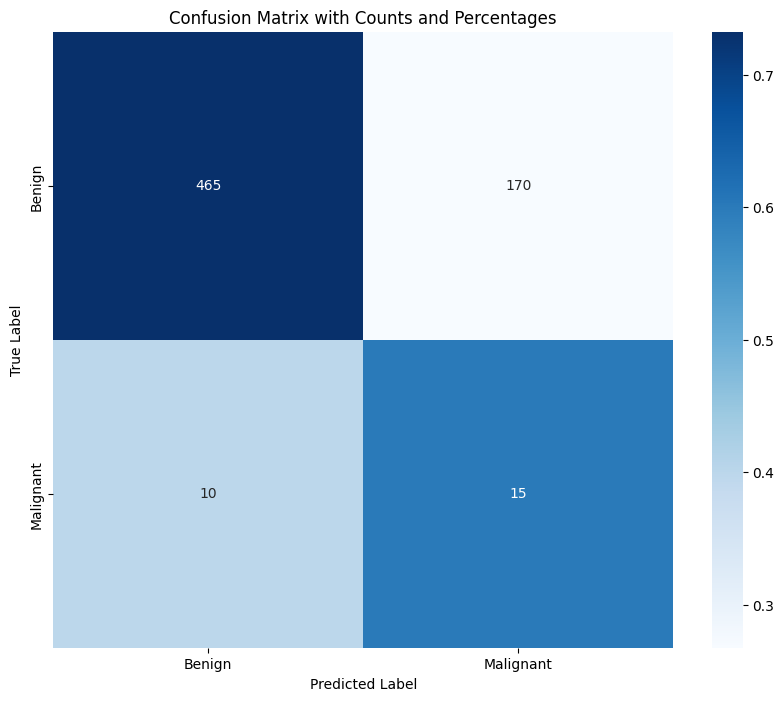

In [30]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pathologies)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', xticklabels=pathologies, yticklabels=pathologies)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Counts and Percentages')
plt.show()